# Decision Tree

Basic steps of the algorithm:
1. Split the data ramdomly **i.e test_df = train_test_split(df, test_size_proportion = 0.2** into:
    1. Traning data **i.e train_df**
    2. Testing data **i.e test_df**
2. Apply the decision tree algo **tree = decision_tree_algorithm(i.e train_df)** on the training data **i.e train_df**
3. Test the trained model on testing data to get the accuracy **i.e accuracy = calculate_accuracy(test_df, tree)**


In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#To allow matplotlib charts to be displayed inside our notebook
%matplotlib inline

import random
from pprint import pprint

### 1. LOAD AND PREPARE DATA

**General format of data**:
    1. Last column of the data frame must contain the label as result.
    2. There should be no missing value in the data frame

In [2]:
df = pd.read_csv("iris.csv")
df = df.rename(columns = {"species":"class"})
df.head()

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


##### TRAIN_TEST_SPLIT function

In [3]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))
        '''
        if number given is float => 
        % of dataset being considered for training df is given
        
        example: if 0.1 is given in, 0.1=10/100 => 10%
        thus 10% of the total number of rows (data) in the dataframe
        will be selected for training the tree
        
        else, if the number is integer(i.e test_size), means it is the number of rows 
        that are chosen not the fraction of rows out of all the present rows
        
        '''
    indices = df.index.tolist()
    test_indices = random.sample(population = indices, k = test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [4]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size = 20)

#Testing the split
test_df.head()

,sepallength,sepalwidth,petallength,petalwidth,class
98,5.1,2.5,3.0,1.1,Iris-versicolor
107,7.3,2.9,6.3,1.8,Iris-virginica
10,5.4,3.7,1.5,0.2,Iris-setosa
66,5.6,3.0,4.5,1.5,Iris-versicolor
130,7.4,2.8,6.1,1.9,Iris-virginica


In [5]:
'''
implementing functions with numpy because pandas makes it slower 
for even small datasets
'''
#df's data into 2D array
data = train_df.values
data[:5]

array([[5.1, 3.5, 1.4, 0.2, 'Iris-setosa'],
       [4.9, 3.0, 1.4, 0.2, 'Iris-setosa'],
       [4.7, 3.2, 1.3, 0.2, 'Iris-setosa'],
       [4.6, 3.1, 1.5, 0.2, 'Iris-setosa'],
       [5.0, 3.6, 1.4, 0.2, 'Iris-setosa']], dtype=object)

### 2. HELPING ALGORITHMIC FUNCTION

##### Purity check funtion

In [6]:
#check purity

'''check if data is pure
i.e check if there is some part of the data that lies completely 
separated from the other => definite boundry can be found for 
some labels such that dataset of one label does not interfere in
the dataset of the other label
'''
def check_purity(data):
    result_column = data[:, -1]
    unique_classes = np.unique(result_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [7]:
#Testing the purity function
'''
in the Iris dataset,
all the flowers with petal width less than 0.8 are Iris-setosa,
no other species lies in that region 
i.e. no other label interferes thus testing for all data less than 0.8
in width of petals should give true as all lying in this region
are iris setosa
'''
print(check_purity(train_df[train_df.petalwidth < 0.8].values))

'''
all flowers with width greater than 0.8 are not of the same type
thus this should return false
'''
print(check_purity(train_df[train_df.petalwidth > 0.8].values))

True
False


##### Data classifying function

In [8]:
#classify
'''
it not only classifies the data when it is pure
but it also classifies the data when not completely pure 
based on the majority of species 
i.e which ever result appears most frequently
'''
def classify_data(data):
    result_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(result_column, return_counts = True)
    
    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [9]:
'''
checking major label present in a region of distribution
'''

print(classify_data(train_df[train_df.petalwidth < 0.8].values))
print(classify_data(train_df[train_df.petalwidth > 0.8].values))
print(classify_data(train_df[train_df.petalwidth < 1.2].values))
print(classify_data(train_df[train_df.petalwidth > 1.2].values))
print(classify_data(train_df[(train_df.petalwidth > 1.2) & (train_df.petalwidth < 1.8)].values))

Iris-setosa
Iris-versicolor
Iris-setosa
Iris-virginica
Iris-versicolor


##### Potential split function

In [10]:
train_df.head()

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [11]:
def get_potential_splits(data):
    
    potential_splits = {}
    #getting the columns
    _, n_columns = data.shape
    '''Now for checking potential splits,
    we get all the unique values that are there
    in each of the column (i.e column-wise)
    '''
    for column_index in range(n_columns - 1):# excluding the last column which is the label
        potential_splits[column_index] = []
        values = data[:, column_index]#getting all the values of column
        unique_values = np.unique(values)#filtering the unique values
        '''
        Having the all the unique values in each column,
        the general idea is to consider all value present 
        exactly in the middle of any 2 unique value as a potential split
        '''
        for index in range(len(unique_values)):
            if index != 0:#skipping the first element
                current_value = unique_values[index]
                previous_value = unique_values[index - 1]
                potential_split = (current_value + previous_value) / 2 #getting the middle value
                
                potential_splits[column_index].append(potential_split)
    
    return potential_splits

In [12]:
potential_splits = get_potential_splits(train_df.values)

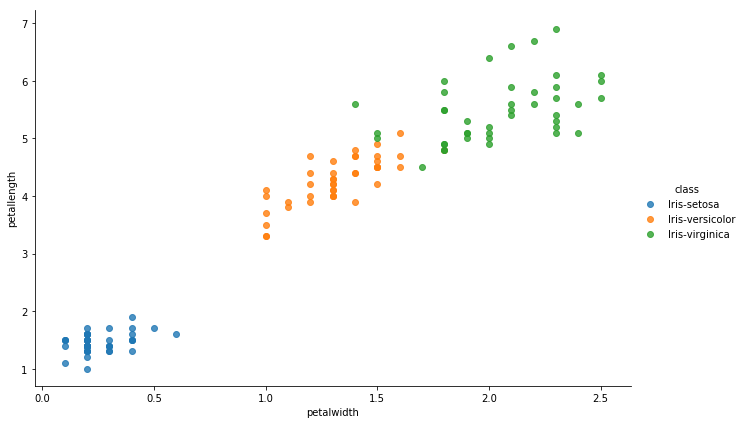

In [13]:
#scatterplot of petal_width vs petal_length
sns.lmplot(data=train_df, x="petalwidth", y="petallength",hue="class",
           fit_reg=False,height=6,aspect=1.5)

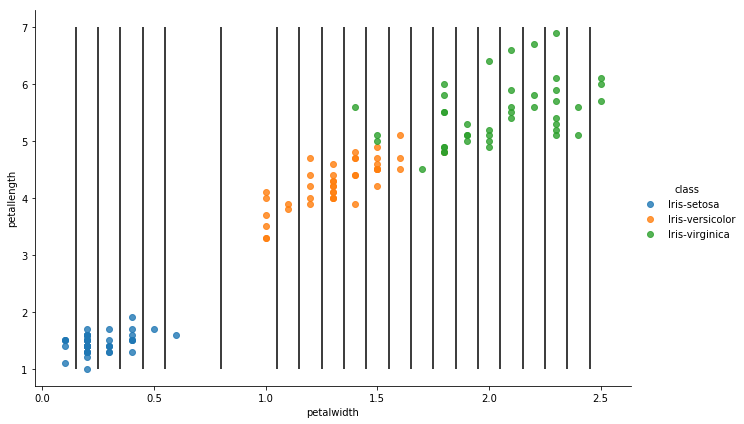

In [14]:
'''checking the potential width function for petalwidth (i.e vertically)'''
sns.lmplot(data=train_df, x="petalwidth", y="petallength",hue="class",
           fit_reg=False,height=6,aspect=1.5)
plt.vlines(x=potential_splits[3],ymin=1,ymax=7)

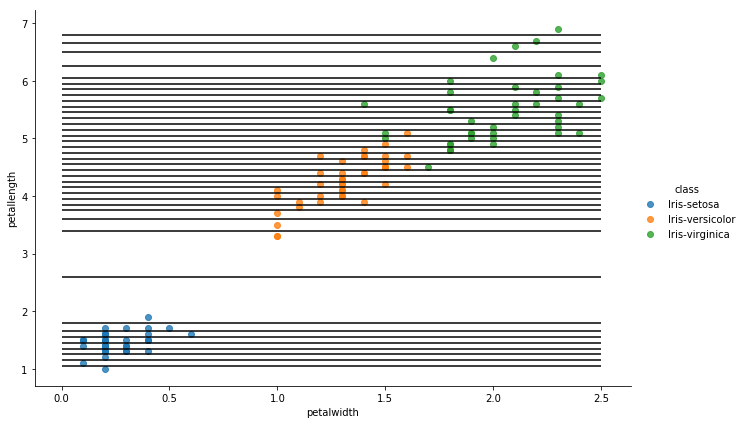

In [15]:
'''checking the potential width function for petal_length (i.e horizontlly)'''
sns.lmplot(data=train_df, x="petalwidth", y="petallength",hue="class",
           fit_reg=False,height=6,aspect=1.5)
plt.hlines(y=potential_splits[2],xmin=0,xmax=2.5)

##### Split the data

In [16]:
def split_data(data, split_column, split_value):
    '''
    the data is split w.r.t the respective column,
    and based on the appropriate split value into
    data below the value and above the line
    '''
    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >  split_value]
    
    return data_below, data_above

In [17]:
#checking the split function
split_column=3
split_value=0.8
data_below, data_above = split_data(data,split_column,split_value)

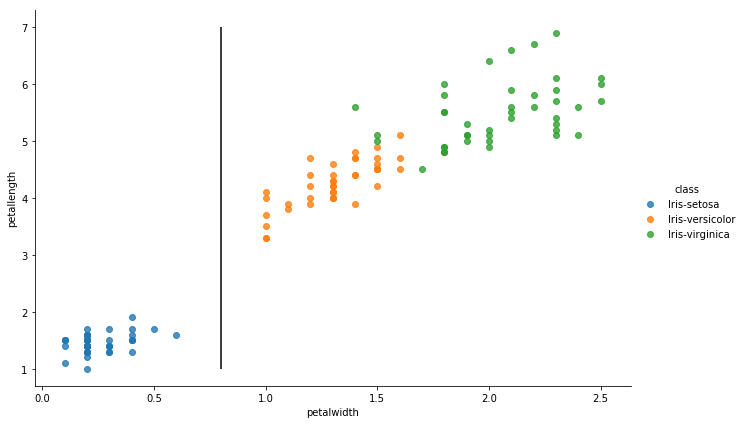

In [18]:
#visualizing and testing split function using scatterplot
plotting_df = pd.DataFrame(data,columns=df.columns)

sns.lmplot(data=plotting_df, x="petalwidth", y="petallength",hue="class",
           fit_reg=False,height=6,aspect=1.5)
plt.vlines(x=split_value, ymin=1, ymax=7)

(0, 2.6)

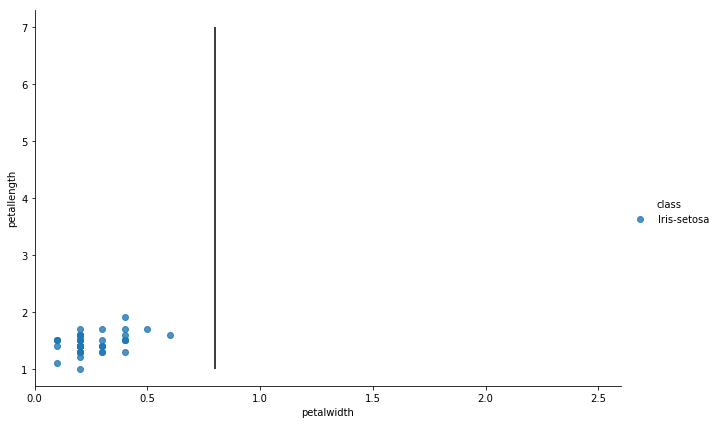

In [19]:
#visualizing data below the split using scatterplot
plotting_df = pd.DataFrame(data_below,columns=df.columns)

sns.lmplot(data=plotting_df, x="petalwidth", y="petallength",hue="class",
           fit_reg=False,height=6,aspect=1.5)
plt.vlines(x=split_value, ymin=1, ymax=7)
plt.xlim(0,2.6)

(0, 2.6)

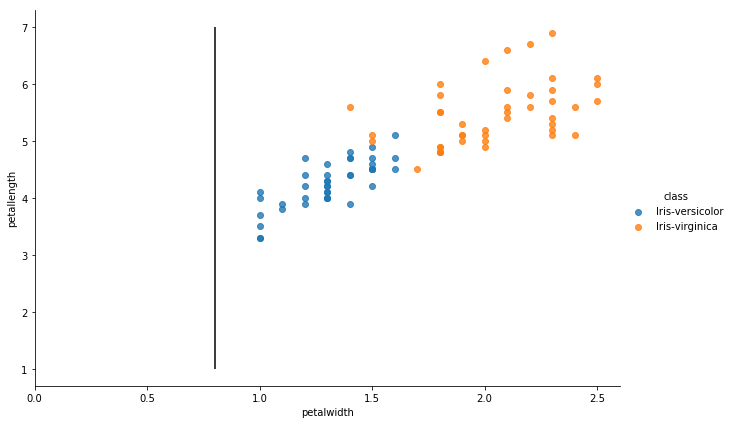

In [20]:
#visualizing data above the split using scatterplot
plotting_df = pd.DataFrame(data_above,columns=df.columns)

sns.lmplot(data=plotting_df, x="petalwidth", y="petallength",hue="class",
           fit_reg=False,height=6,aspect=1.5)
plt.vlines(x=split_value, ymin=1, ymax=7)
plt.xlim(0,2.6)

##### Calculating the Entropy

In [21]:
def calculate_entropy(data):
    
    result_column = data[:, -1]
    _, counts = np.unique(result_column, return_counts=True)
    #Above is to get individual count of result species respectively 
    probabilities = counts / counts.sum()#probability = individual / total
    entropy = sum(probabilities * -np.log2(probabilities))#Entropy = summationof(p(i)*(-log2(p(i))))
     
    return entropy

In [22]:
#Testing the entropy function
print(calculate_entropy(data_below))
print(calculate_entropy(data_above))

0.0
1.0


0.5159469300074474
0.9957274520849255


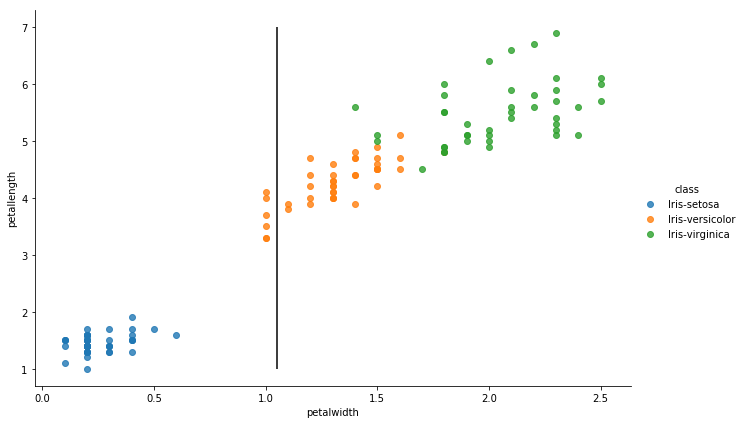

In [23]:
#Testing the entropy for some other split value
split_column=3
split_value=1.05
data_below, data_above = split_data(data,split_column,split_value)
plotting_df = pd.DataFrame(data,columns=df.columns)

sns.lmplot(data=plotting_df, x="petalwidth", y="petallength",hue="class",
           fit_reg=False,height=6,aspect=1.5)
plt.vlines(x=split_value, ymin=1, ymax=7)
print(calculate_entropy(data_below))
print(calculate_entropy(data_above))

##### Calculate the overall entropy

In [24]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)#total data point
    p_data_below = len(data_below) / n#probability of below data points
    p_data_above = len(data_above) / n#probability of above data points

    overall_entropy =  (p_data_below * calculate_entropy(data_below) #overall entropy = summationof(p(j)*Entropy)
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [25]:
#Testing the overall entropy funtion
split_column=3
split_value=0.8
data_below, data_above = split_data(data,split_column,split_value)
print(calculate_overall_entropy(data_below,data_above))
split_column=3
split_value=1.05
data_below, data_above = split_data(data,split_column,split_value)
print(calculate_overall_entropy(data_below,data_above))

0.6461538461538462
0.8038152432539343


##### Determining the best split

In [26]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999 #arbitary high value
    for column_index in potential_splits:#loop over keys of potential_split dictionary
        for value in potential_splits[column_index]:#loop over value of potential_split dictionary key's
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)
            '''
            Here we calculating the overall entropy of every split
            of each columns and each value,
            and then try to find the minimum overall entropy of all,
            which will be the best split column and the best split value 
            '''
            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [27]:
#Testing the determine best split function
potential_splits = get_potential_splits(data) 

Entropy of below_data = 0.0
Entropy of below_data = 1.0
Entropy of below_data = 0.6461538461538462


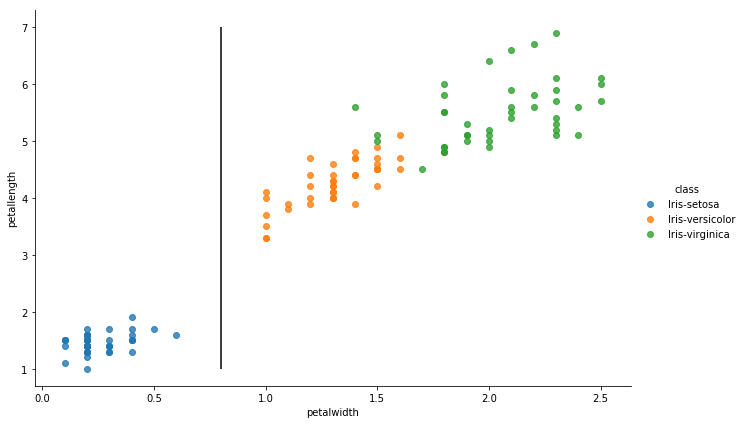

In [28]:
split_column, split_value = determine_best_split(data,potential_splits)
data_below, data_above = split_data(data,split_column,split_value)
plotting_df = pd.DataFrame(data,columns=df.columns)
sns.lmplot(data=plotting_df, x="petalwidth", y="petallength",hue="class",
           fit_reg=False,height=6,aspect=1.5)
plt.vlines(x=split_value, ymin=1, ymax=7)
print("Entropy of below_data = " + str(calculate_entropy(data_below)))
print("Entropy of below_data = " + str(calculate_entropy(data_above)))
print("Entropy of below_data = " + str(calculate_overall_entropy(data_below,data_above)))

### 3. MAIN DECISION TREE ALGORITHM

##### Representation of the tree

In [29]:
sub_tree = {"question": ["yes_answer", #the tree is made up of such dictionary only
                         "no_answer"]}
example_tree = {"petalwidth <= 0.8": ["Iris-setosa", 
                                      {"petalwidth <= 1.65": [{"petallength <= 4.9": ["Iris-versicolor", 
                                                                                        "Iris-virginica"]}, 
                                                                "Iris-virginica"]}]}

In [30]:
'''
Here this has to be a recursive funtion to be able
to call itself again and again so it will take in a 
2d array and give out a 2d array also
'''
def decision_tree_algorithm(df, counter=0): #counter is used for the first call of the function
    
    # data preparations
    if counter == 0:#first call of the function
        data = df.values# as here df is a DataFrame so we have to convert it to 2d array (data)
    else:
        data = df# as this is not the first called so the return value df is a 2d array already
    
    
    # base cases for the recursive function
    if check_purity(data): #if the data is pure than return
        classification = classify_data(data)
        return classification

    
    # the main recursive part
    else:    
        counter += 1
        
        #helping algorithmic function
        potential_splits = get_potential_splits(data)#get all possible splits
        split_column, split_value = determine_best_split(data, potential_splits)#choose best split(i.e lowest overall entropy)
        data_below, data_above = split_data(data, split_column, split_value)#split data based on best split
        
        # instantiate sub-tree
        question = "{} <= {}".format(split_column, split_value)#creates the question
        sub_tree = {question: []}#the empty list will be filled by the yes and no answers
        
        # finding answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter)
        no_answer = decision_tree_algorithm(data_above, counter)
        
        sub_tree[question].append(yes_answer)#appended yes answer
        sub_tree[question].append(no_answer)#appended no answer
        
        return sub_tree

In [31]:
tree = decision_tree_algorithm(train_df)
tree

{'3 <= 0.8': ['Iris-setosa',
  {'3 <= 1.65': [{'2 <= 4.95': ['Iris-versicolor',
      {'3 <= 1.55': ['Iris-virginica', 'Iris-versicolor']}]},
    {'2 <= 4.85': [{'1 <= 3.1': ['Iris-virginica', 'Iris-versicolor']},
      'Iris-virginica']}]}]}

In [32]:
#To make it look pretty
pprint(tree)

{'3 <= 0.8': ['Iris-setosa',
              {'3 <= 1.65': [{'2 <= 4.95': ['Iris-versicolor',
                                            {'3 <= 1.55': ['Iris-virginica',
                                                           'Iris-versicolor']}]},
                             {'2 <= 4.85': [{'1 <= 3.1': ['Iris-virginica',
                                                          'Iris-versicolor']},
                                            'Iris-virginica']}]}]}


## Little modifications

##### Adding feature names in place of the numbers

In [33]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):#base case of when there are only 2 samples
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # instantiate sub-tree
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} <= {}".format(feature_name, split_value)
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        '''
         If the answers are the same, then there is no point in asking the qestion.
         This could happen when the data is classified even though it is not pure
         yet (min_samples or max_depth base cases).
         '''
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [34]:
tree = decision_tree_algorithm(train_df)
pprint(tree)

{'petalwidth <= 0.8': ['Iris-setosa',
                       {'petalwidth <= 1.65': [{'petallength <= 4.95': ['Iris-versicolor',
                                                                        {'petalwidth <= 1.55': ['Iris-virginica',
                                                                                                'Iris-versicolor']}]},
                                               {'petallength <= 4.85': [{'sepalwidth <= 3.1': ['Iris-virginica',
                                                                                               'Iris-versicolor']},
                                                                        'Iris-virginica']}]}]}


### 4. Classification

In [35]:
sub_tree

{'question': ['yes_answer', 'no_answer']}

In [36]:
example = test_df.iloc[0]# the testing data set(unknown data)
example

sepallength                5.1
sepalwidth                 2.5
petallength                  3
petalwidth                 1.1
class          Iris-versicolor
Name: 98, dtype: object

In [37]:
def classify_example(example, tree):
    question = list(tree.keys())[0]#the question based on which the splitting occur
    feature_name, comparison_operator, value = question.split()#attributes of the answer

    # ask question
    if example[feature_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):#answer not a dictionary
        return answer
    
    # recursive part
    else:#answer is a dictionary
        residual_tree = answer
        return classify_example(example, residual_tree)

In [38]:
#Testing in the testing data
classify_example(example,tree)

'Iris-versicolor'

In [39]:
example = test_df.iloc[1]
example

sepallength               7.3
sepalwidth                2.9
petallength               6.3
petalwidth                1.8
class          Iris-virginica
Name: 107, dtype: object

In [40]:
classify_example(example,tree)

'Iris-virginica'

In [41]:
example = test_df.iloc[2]
example

sepallength            5.4
sepalwidth             3.7
petallength            1.5
petalwidth             0.2
class          Iris-setosa
Name: 10, dtype: object

In [42]:
classify_example(example,tree)

'Iris-setosa'

In [43]:
print("so it seems to be working....")

so it seems to be working....


### Accuracy

In [44]:
def calculate_accuracy(df, tree):

    '''
    We add 2 more columns to our DataFrame,
    one is classification which contents the results of our tree
    the other is the boolean values which gives true if both our results are matched
    and false if the results dont match,
    the mean is calculted for accuracy 
    '''
    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["class"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

In [45]:
calculate_accuracy(test_df,tree)

0.9

In [46]:
test_df

,sepallength,sepalwidth,petallength,petalwidth,class,classification,classification_correct
98,5.1,2.5,3.0,1.1,Iris-versicolor,Iris-versicolor,True
107,7.3,2.9,6.3,1.8,Iris-virginica,Iris-virginica,True
10,5.4,3.7,1.5,0.2,Iris-setosa,Iris-setosa,True
66,5.6,3.0,4.5,1.5,Iris-versicolor,Iris-versicolor,True
130,7.4,2.8,6.1,1.9,Iris-virginica,Iris-virginica,True
124,6.7,3.3,5.7,2.1,Iris-virginica,Iris-virginica,True
103,6.3,2.9,5.6,1.8,Iris-virginica,Iris-virginica,True
77,6.7,3.0,5.0,1.7,Iris-versicolor,Iris-virginica,False
122,7.7,2.8,6.7,2.0,Iris-virginica,Iris-virginica,True
91,6.1,3.0,4.6,1.4,Iris-versicolor,Iris-versicolor,True


In [47]:
# is giving false on test_df.loc[77]
# is giving false on test_df.loc[129]